### Exploratory Data Analysis

In [1]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from random import choices
import copy 
import os 
import cv2
import random
import matplotlib.image as mpimg
from matplotlib.image import imread
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import itertools
import tensorflow as tf
import keras
import keras.utils
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/malignant-lymphoma-classification")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 1.34G/1.34G [01:13<00:00, 19.8MB/s]

Extracting files...


Path to dataset files: C:\Users\frank\.cache\kagglehub\datasets\andrewmvd\malignant-lymphoma-classification\versions\1


In [3]:
#Define Classes
CLL = r'C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/CLL'
FL = r'C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/FL'
MCL = r'C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/MCL'


Class Distribution: {'CLL': 113, 'FL': 139, 'MCL': 122}


C:\Users\frank\AppData\Local\Temp\ipykernel_14536\2299590854.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


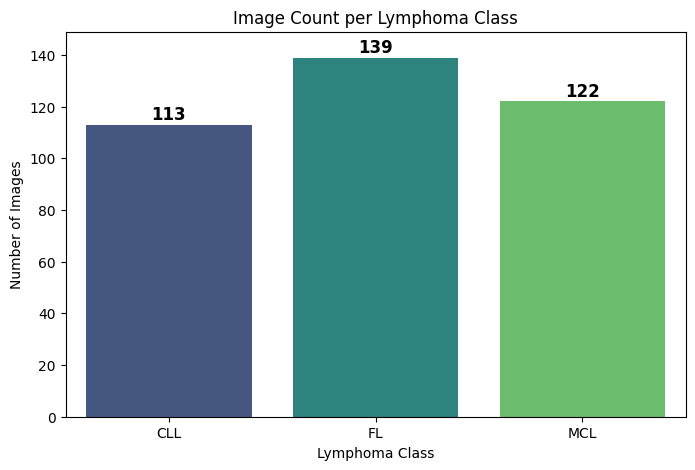

In [4]:
# Define dataset paths
folders = {
    "CLL": r"C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/CLL",
    "FL": r"C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/FL",
    "MCL": r"C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/MCL"
}

# Function to count images in each class
def count_images(folders):
    class_counts = {cls: len(os.listdir(path)) for cls, path in folders.items()}
    return class_counts

# Get class distribution
class_counts = count_images(folders)
print("Class Distribution:", class_counts)

# Plot class distribution with counts
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")

# Add text labels on top of bars
for i, count in enumerate(class_counts.values()):
    ax.text(i, count + 2, str(count), ha='center', fontsize=12, fontweight='bold')

plt.title("Image Count per Lymphoma Class")
plt.ylabel("Number of Images")
plt.xlabel("Lymphoma Class")
plt.ylim(0, max(class_counts.values()) + 10)  # Adjust y-axis for better visibility
plt.show()

In [5]:
# Function to display 5 random images and print their sizes
def show_imgs(img_folder, class_name):
    plt.figure(figsize=(15, 3))  # Set figure size
    plt.suptitle(f"Class: {class_name}", fontsize=16)  # Add class title

    for i in range(5):  # Show 5 images
        file = random.choice(os.listdir(img_folder))
        image_path = os.path.join(img_folder, file)
        
        # Load and display image
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i + 1)
        ax.set_title(file, fontsize=8)  # Show filename
        plt.imshow(img)
        plt.axis("off")

        # Print image resolution
        with Image.open(image_path) as img_pil:
            print(f"Image: {file}, Size: {img_pil.size}")  # Print resolution

    plt.show()


Image: sj-03-2810_008.tif, Size: (1388, 1040)
Image: sj-03-476_002.tif, Size: (1388, 1040)
Image: sj-03-852-R2_006.tif, Size: (1388, 1040)
Image: sj-05-3344_011.tif, Size: (1388, 1040)
Image: sj-03-5521_003.tif, Size: (1388, 1040)


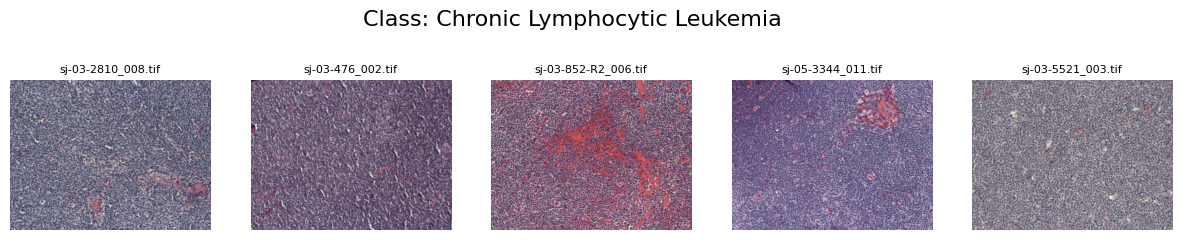

In [6]:
# Example usage for CLL
show_imgs(CLL, "Chronic Lymphocytic Leukemia")

Image: sj-05-588-R1_005.tif, Size: (1388, 1040)
Image: sj-05-1881-R1_010.tif, Size: (1388, 1040)
Image: sj-05-1881-R1_012.tif, Size: (1388, 1040)
Image: sj-05-5311-R1_003.tif, Size: (1388, 1040)
Image: sj-05-6124-R3_013.tif, Size: (1388, 1040)


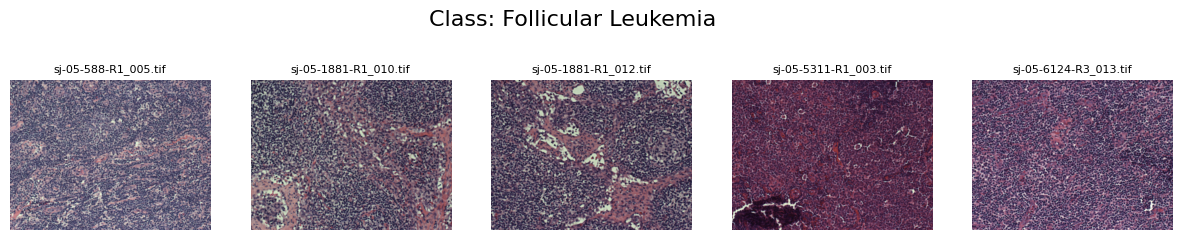

In [7]:
#Print 5 images and sizes from FL
show_imgs(FL, "Follicular Leukemia")

Image: sj-05-5326-R1_001.tif, Size: (1388, 1040)
Image: sj-05-768_013.tif, Size: (1388, 1040)
Image: sj-04-4525-R4_010.tif, Size: (1388, 1040)
Image: sj-04-4967-R2_006.tif, Size: (1388, 1040)
Image: sj-05-901-R1_008.tif, Size: (1388, 1040)


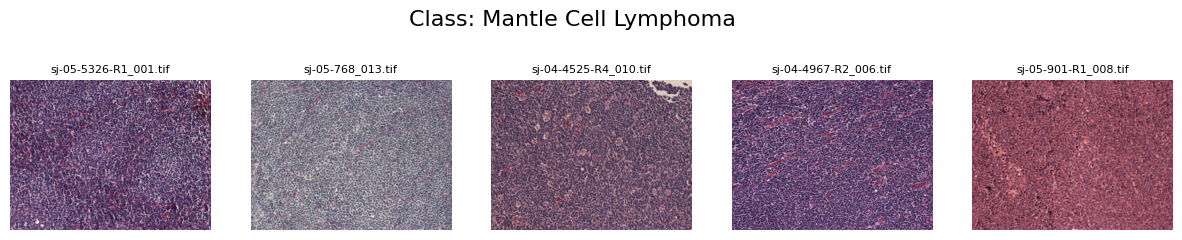

In [8]:
#Print 5 images and sizes from MCL
show_imgs(MCL, "Mantle Cell Lymphoma")

### Data Preprocessing

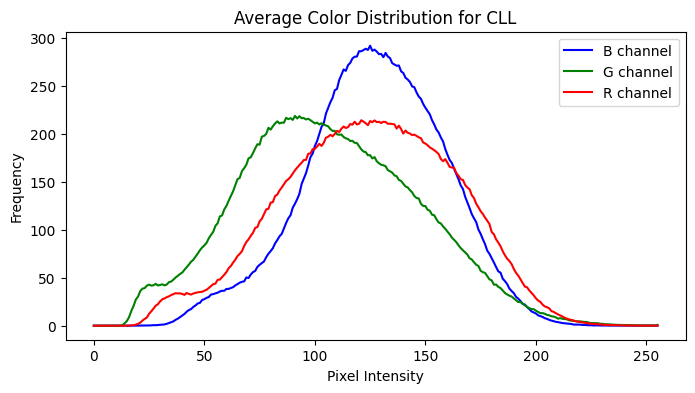

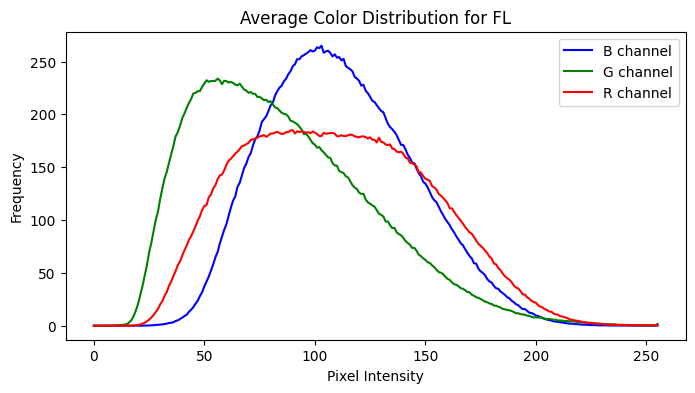

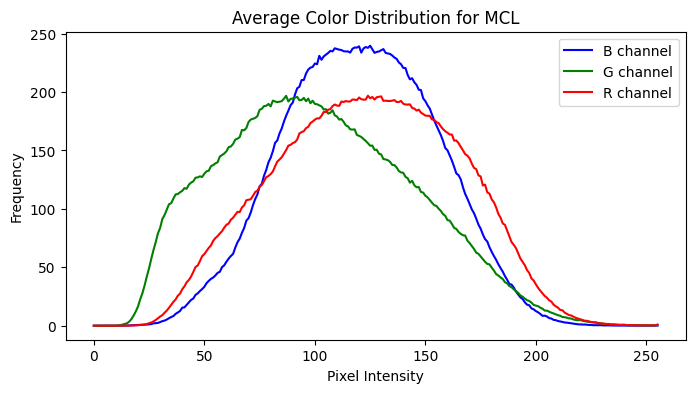

In [9]:
# Function to compute the average color histogram for a class
def compute_avg_histogram(img_folder, class_name):
    color = ('b', 'g', 'r')  # OpenCV uses BGR format
    histograms = []

    # Process all images in the folder
    for file in os.listdir(img_folder):
        image_path = os.path.join(img_folder, file)
        img = cv2.imread(image_path)  # Read image
        if img is None:
            continue
        
        img = cv2.resize(img, (150, 150))  # Resize for consistency
        
        hist = []
        for i, col in enumerate(color):
            hist_channel = cv2.calcHist([img], [i], None, [256], [0, 256])  # Compute histogram
            hist.append(hist_channel)
        
        histograms.append(hist)

    # Compute average histogram across all images
    avg_hist = np.mean(histograms, axis=0)

    # Plot histogram
    plt.figure(figsize=(8, 4))
    for i, col in enumerate(color):
        plt.plot(avg_hist[i], color=col, label=f"{col.upper()} channel")
    
    plt.title(f"Average Color Distribution for {class_name}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Analyze color distribution for each lymphoma class
for class_name, folder in folders.items():
    compute_avg_histogram(folder, class_name)

In [10]:
#  Paths to the image folders
base_dir = r'C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/'
folders = ['CLL', 'FL', 'MCL']

# Creating directories for training and test data
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Creating subfolders for classes in train and test directories
class_names = ['CLL', 'FL', 'MCL']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Function to split data and move files
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = os.listdir(SOURCE)
    images = [f for f in all_files if os.path.isfile(os.path.join(SOURCE, f))]

    train_images, test_images = train_test_split(images, test_size=SPLIT_SIZE, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(SOURCE, image), os.path.join(TRAINING, image))

    for image in test_images:
        shutil.copy(os.path.join(SOURCE, image), os.path.join(TESTING, image))

# Split ratio (e.g. 0.2 means 20% of data for testing)
split_ratio = 0.2

# Loop over the folders, split and copy files into train/test folders
for i, folder in enumerate(folders):
    source_dir = os.path.join(base_dir, folder)
    training_class_dir = os.path.join(train_dir, class_names[i])
    testing_class_dir = os.path.join(test_dir, class_names[i])
    
    split_data(source_dir, training_class_dir, testing_class_dir, split_ratio)

print("✅ Data successfully split into training and test sets.")

✅ Data successfully split into training and test sets.


Class Labels: {'CLL': 0, 'FL': 1, 'MCL': 2}


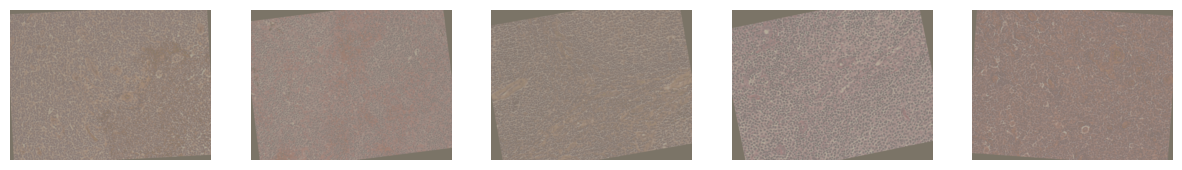

In [11]:
# 3️⃣ Ensure reproducibility
torch.manual_seed(42)

# Define Image Preprocessing 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# 5️⃣ Load dataset using PyTorch ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# 6️⃣ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify class mappings
print("Class Labels:", train_dataset.class_to_idx)

# 7️⃣ Check Example Images After Preprocessing
def show_transformed_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        img = img.clip(0, 1)  # Keep values between 0-1
        
        axes[i].imshow(img)
        axes[i].axis("off")
    
    plt.show()

show_transformed_images(train_loader)

In [12]:
# Define paths
base_dir = r'C:/Users/frank/.cache/kagglehub/datasets/andrewmvd/malignant-lymphoma-classification/versions/1/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [13]:
# Ensure reproducibility
torch.manual_seed(42)
def apply_hist_eq(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Convert to YUV color space
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Equalize only the Y (luminance) channel
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)  # Convert back to RGB
    return img_eq

# Function to apply CLAHE (Adaptive Histogram Equalization)
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return img_clahe

# Custom preprocessing (Apply HE/CLAHE randomly)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, apply_clahe_prob=0.3):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform
        self.apply_clahe_prob = apply_clahe_prob  # Probability of applying CLAHE
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply CLAHE to ~30% of images
        if np.random.rand() < self.apply_clahe_prob:
            image = apply_clahe(image)

        # Convert to PIL image before applying PyTorch transformations
        image = transforms.ToPILImage()(image)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [14]:
# Ensure reproducibility
torch.manual_seed(42)

# Function to count images per class
def count_images(dataset):
    class_counts = Counter(dataset.targets)
    return class_counts

# Load dataset without transformations to get class counts
dataset_temp = ImageFolder(root=train_dir)
class_counts = count_images(dataset_temp)
max_class_size = max(class_counts.values())  # Find the largest class

# Define Transformations (For ResNet-50)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet-50 normalization
])

# Custom dataset with oversampling
class BalancedDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform
        self.classes = self.dataset.classes
        self.class_indices = {cls: [] for cls in self.dataset.class_to_idx}

        # Store indices of each class
        for idx, (_, label) in enumerate(self.dataset.samples):
            self.class_indices[self.dataset.classes[label]].append(idx)

        # Oversample minority classes
        self.balanced_samples = []
        for cls, indices in self.class_indices.items():
            oversampled_indices = choices(indices, k=max_class_size)  # Duplicate until max size
            self.balanced_samples.extend(oversampled_indices)

    def __len__(self):
        return len(self.balanced_samples)

    def __getitem__(self, idx):
        original_idx = self.balanced_samples[idx]
        image_path, label = self.dataset.samples[original_idx]

        image = Image.open(image_path).convert("RGB")  # Load image
        if self.transform:
            image = self.transform(image)

        return image, label

# Load balanced dataset
train_dataset = BalancedDataset(root_dir=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)  # No oversampling for test set

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify new class distribution
def count_images(dataset):
    class_counts = Counter([dataset.dataset.samples[idx][1] for idx in dataset.balanced_samples])
    return class_counts


In [15]:
# Verify new class distribution
balanced_train_counts = count_images(train_dataset)
print("Balanced Class Distribution:", balanced_train_counts)

Balanced Class Distribution: Counter({0: 111, 1: 111, 2: 111})


### Model

In [16]:
import torchvision.models as models
import torch.nn as nn

# Load Pretrained ResNet-50
model = models.resnet50(weights=True)

# Modify the final fully connected layer for 3 lymphoma classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Freeze all layers except the last ResNet block (layer4)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers initially

for param in model.layer4.parameters():
    param.requires_grad = True  # Unfreeze layer4 for fine-tuning

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

C:\Users\frank\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

# Define optimizer, loss, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

# Early stopping parameters
early_stopping_patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

# Training function with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100):
    global best_val_loss, epochs_no_improve

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        
        # Calculate validation loss
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_accuracy = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {correct/total:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Train for 100 epochs with early stopping
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100)

# Load best model after training
model.load_state_dict(torch.load("best_model.pth"))


Epoch 1/100, Train Loss: 0.9228, Train Accuracy: 0.5495, Val Loss: 0.9559, Val Accuracy: 0.6053
Epoch 2/100, Train Loss: 0.8952, Train Accuracy: 0.6066, Val Loss: 0.9044, Val Accuracy: 0.6316
Epoch 3/100, Train Loss: 0.7285, Train Accuracy: 0.7027, Val Loss: 0.7755, Val Accuracy: 0.5921
Epoch 4/100, Train Loss: 0.5775, Train Accuracy: 0.7688, Val Loss: 0.7679, Val Accuracy: 0.5921
Epoch 5/100, Train Loss: 0.5492, Train Accuracy: 0.7598, Val Loss: 0.6786, Val Accuracy: 0.7237
Epoch 6/100, Train Loss: 0.4616, Train Accuracy: 0.8228, Val Loss: 0.6499, Val Accuracy: 0.7500
Epoch 7/100, Train Loss: 0.3926, Train Accuracy: 0.8438, Val Loss: 0.9864, Val Accuracy: 0.6974
Epoch 8/100, Train Loss: 0.3402, Train Accuracy: 0.8589, Val Loss: 0.5894, Val Accuracy: 0.7105
Epoch 9/100, Train Loss: 0.2407, Train Accuracy: 0.9219, Val Loss: 0.6892, Val Accuracy: 0.7368
Epoch 10/100, Train Loss: 0.2524, Train Accuracy: 0.9159, Val Loss: 0.6493, Val Accuracy: 0.7237
Epoch 11/100, Train Loss: 0.2646, Train

C:\Users\frank\AppData\Local\Temp\ipykernel_14536\3147016310.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = loss_total / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluate Model
evaluate_model(model, test_loader)


Test Loss: 0.5608, Test Accuracy: 0.8289


0.8289473684210527

Accuracy: 0.8026
F1 Score: 0.8011
AUC-ROC: 0.9171


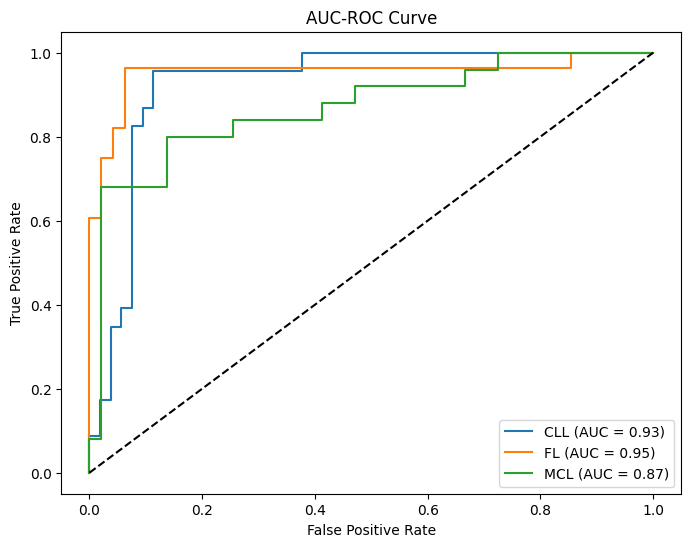

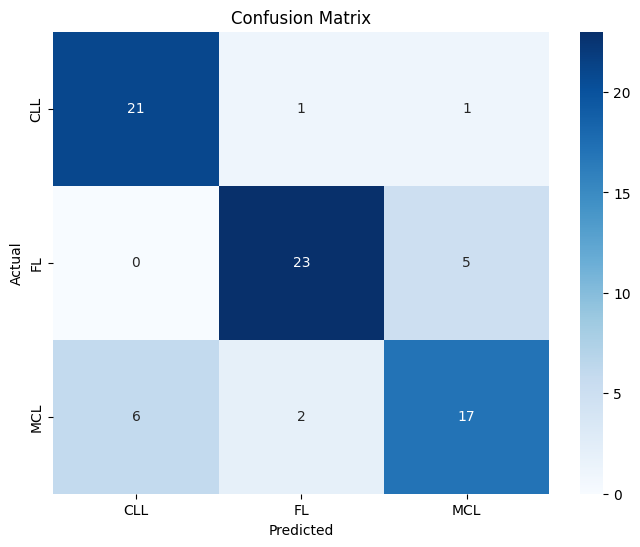

              precision    recall  f1-score   support

         CLL       0.78      0.91      0.84        23
          FL       0.88      0.82      0.85        28
         MCL       0.74      0.68      0.71        25

    accuracy                           0.80        76
   macro avg       0.80      0.80      0.80        76
weighted avg       0.80      0.80      0.80        76



In [19]:
# Define function to evaluate model on test set
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute Accuracy and F1 Score
    from sklearn.metrics import accuracy_score, f1_score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Compute AUC-ROC for each class
    roc_auc = roc_auc_score(np.eye(len(class_names))[all_labels], all_probs, multi_class='ovr')
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_score(np.array(all_labels) == i, np.array(all_probs)[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend()
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print detailed classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Define class names
class_names = ["CLL", "FL", "MCL"]

# Evaluate the model
evaluate_model(model, test_loader, class_names)

In [20]:
# Save the model
torch.save(model.state_dict(), "lymphoma_classifier.pth")

# To load it later:
# model.load_state_dict(torch.load("lymphoma_classifier.pth"))
# model.eval()  # Set to evaluation mode
